# Indoor Scene Recognition using PyTorch

Indoor scene recognition is a challenging open problem in high level vision. Most scene recognition models that work well for outdoor scenes perform poorly in the indoor domain. The main difficulty is that while some indoor scenes (e.g. corridors) can be well characterized by global spatial properties, others (e.g., bookstores) are better characterized by the objects they contain. More generally, to address the indoor scenes recognition problem we need a model that can exploit local and global discriminative information.

![Garbage Bins](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-61705-9_64/MediaObjects/500677_1_En_64_Fig1_HTML.png)


In this notebook we'll use PyTorch for classifying the indoor scene into various categories like bakery, casino, etc.

Let us start by importing the libraries:

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

random_seed = 213
torch.manual_seed(random_seed)

# Database

The database contains 67 Indoor categories, and a total of 15620 images. The number of images varies across categories, but there are at least 100 images per category. All images are in jpg format. The images provided here are for research purposes only.

In [2]:
data_dir  = '../data/Images'

classes = os.listdir(data_dir)
print(classes)
print(f"length: {len(classes)}")

['artstudio', 'bathroom', 'bedroom', 'children_room', 'closet', 'computerroom', 'dining_room', 'gameroom', 'kitchen', 'livingroom', 'locker_room', 'meeting_room']
length: 12


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

dataset = ImageFolder(data_dir, transform = transformations)
print(f"dataset size: {len(dataset)}")

dataset size: 3683


Label:bedroom (Class No: 2)


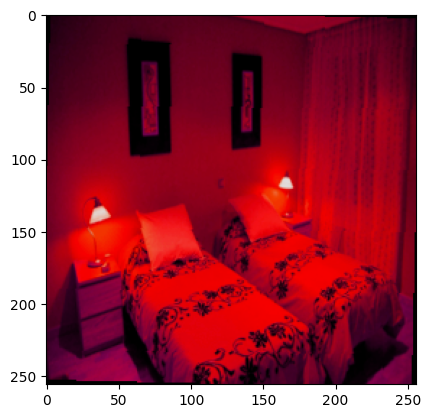

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print(f"Label:{dataset.classes[label]} (Class No: {label})")
    plt.imshow(img.permute(1, 2, 0))

img, label = dataset[666]
show_sample(img, label)

In [6]:
from torch.utils.data.dataloader import DataLoader

batch_size = 64
train_ds, val_ds, test_ds = random_split(dataset, [2800, 500, 383])
# print(f"train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

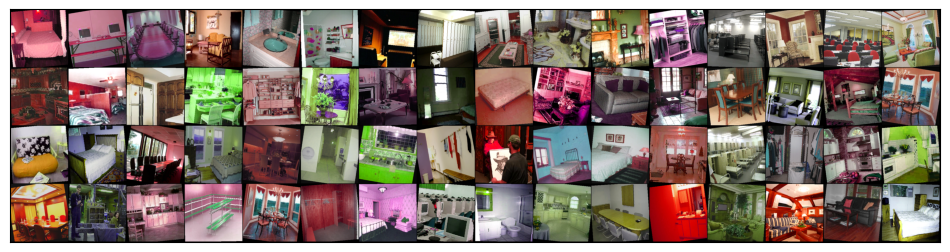

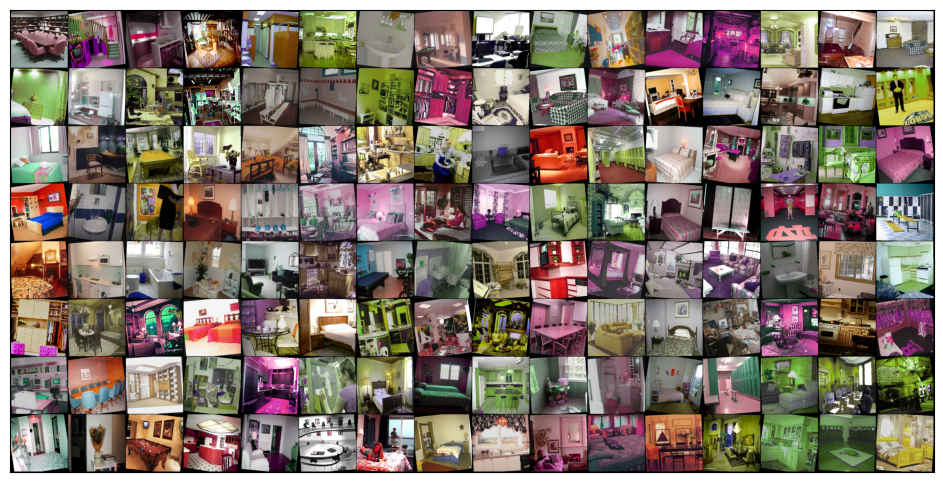

In [7]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

show_batch(train_loader)
show_batch(val_loader)

# Model:

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    acc = torch.sum(preds == labels).item() / len(preds)
    return acc

class ConvClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torchvision.models.resnet18(pretrained=True)
        self.network.fc = nn.Linear(self.network.fc.in_features, len(dataset.classes))  # 修改最后一层
    
    def forward(self, xb):
        return self.network(xb)
    
    def training_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # cross entropy 内部已包含 softmax， 所以外部就不激活了
        return loss
    
    @torch.no_grad()
    def valid_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device) 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.item(), 'val_acc': acc}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvClassifier().to(device)
optim = torch.optim.Adam(model.parameters(), 6e-5)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training the Model:

In [13]:
import numpy as np
history = []

In [14]:
num_epochs = 20

for epoch in range(num_epochs):  # Training Phase
    model.train()
    train_losses = []
    for batch in train_loader:
        loss = model.training_step(batch)
        optim.zero_grad()
        loss.backward()
        optim.step()

        train_losses.append(loss.item())

    # Validation phase
    model.eval()
    outputs = [model.valid_step(batch) for batch in val_loader]
    result = {
        'val_loss': np.mean([out['val_loss'] for out in outputs]), 
        'val_acc': np.mean([out['val_acc'] for out in outputs]), 
        'train_loss': np.mean(train_losses)
    }
    print(f"[Epoch {epoch+1}] train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
    history.append(result)

[Epoch 1] train_loss: 1.8640, val_loss: 1.1206, val_acc: 0.6451
[Epoch 2] train_loss: 0.8710, val_loss: 0.7652, val_acc: 0.7733
[Epoch 3] train_loss: 0.5726, val_loss: 0.6467, val_acc: 0.7891
[Epoch 4] train_loss: 0.4323, val_loss: 0.5574, val_acc: 0.8288
[Epoch 5] train_loss: 0.3279, val_loss: 0.5916, val_acc: 0.8099
[Epoch 6] train_loss: 0.2437, val_loss: 0.5400, val_acc: 0.8171
[Epoch 7] train_loss: 0.1883, val_loss: 0.5163, val_acc: 0.8357


In [ ]:
"""
[Epoch 1] train_loss: 2.7242, val_loss: 1.8789, val_acc: 0.5482
[Epoch 2] train_loss: 1.5232, val_loss: 1.3625, val_acc: 0.6569
[Epoch 3] train_loss: 1.0987, val_loss: 1.1306, val_acc: 0.6949
[Epoch 4] train_loss: 0.8508, val_loss: 1.0211, val_acc: 0.7330
[Epoch 5] train_loss: 0.6742, val_loss: 0.9465, val_acc: 0.7448
[Epoch 6] train_loss: 0.5346, val_loss: 0.9108, val_acc: 0.7581
[Epoch 7] train_loss: 0.4328, val_loss: 0.9318, val_acc: 0.7486
[Epoch 8] train_loss: 0.3470, val_loss: 0.8633, val_acc: 0.7585
[Epoch 9] train_loss: 0.2697, val_loss: 0.8630, val_acc: 0.7647
[Epoch 10] train_loss: 0.2203, val_loss: 0.8796, val_acc: 0.7513
[Epoch 11] train_loss: 0.1790, val_loss: 0.8602, val_acc: 0.7627
[Epoch 12] train_loss: 0.1481, val_loss: 0.8460, val_acc: 0.7630
[Epoch 13] train_loss: 0.1190, val_loss: 0.8709, val_acc: 0.7656
[Epoch 14] train_loss: 0.0950, val_loss: 0.8775, val_acc: 0.7508
[Epoch 15] train_loss: 0.0823, val_loss: 0.8710, val_acc: 0.7709
[Epoch 16] train_loss: 0.0656, val_loss: 0.9006, val_acc: 0.7539
[Epoch 17] train_loss: 0.0618, val_loss: 0.8573, val_acc: 0.7714
[Epoch 18] train_loss: 0.0531, val_loss: 0.9101, val_acc: 0.7634
[Epoch 19] train_loss: 0.0531, val_loss: 0.8790, val_acc: 0.7681
[Epoch 20] train_loss: 0.0450, val_loss: 0.8850, val_acc: 0.7629
"""

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('resnet-18');

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Train loss', 'Val loss'])
    plt.title('mobilenet_v2');

plot_losses(history)

In [ ]:
torch.save(model.state_dict(), "mobilenet_v2.pth")

In [ ]:
import 
model.loac_state_dict()

# Visualizing Predictions:

In [ ]:
def predict_image(img):
    xb = img.unsqueeze(0).to(device)         # Convert to a batch of 1
    yb = model(xb)                           # Get predictions from model
    prob, preds  = torch.max(yb, dim=1)      # Pick index with highest probability
    return dataset.classes[preds[0].item()]  # Retrieve the class label

Let us see the model's predictions on the test dataset:

In [ ]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# Predicting External Images:

Let's now test with external images.

I'll use `urllib` for downloading external images.

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://images.squarespace-cdn.com/content/v1/5a7497e29f8dcee376b70f7e/1591630503059-FBBWAYXPWYOK9BTIBMZY/ke17ZwdGBToddI8pDm48kA_SSaoz4elkj-HsZd8gX3Z7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UWPwZyNcweDIvdeL5kotwkIXjs9g0WibSO_cU-Ijy4Pwg6poS-6WGGnXqDacZer4yQ/74586587_10157705983079085_1307946016988725248_o+%281%29.jpg?format=2500w", "bar.jpg")
urllib.request.urlretrieve("https://www.bocadolobo.com/en/inspiration-and-ideas/wp-content/uploads/2018/03/Discover-the-Ultimate-Master-Bedroom-Styles-and-Inspirations-6_1.jpg", "bedroom.jpg")    
urllib.request.urlretrieve("https://sika.scene7.com/is/image/sika/glo-elevator-appliances?wid=1280&crop=0%2C80%2C4615%2C3212", "elevator.jpg") 
urllib.request.urlretrieve("https://i.pinimg.com/originals/2b/15/9d/2b159da035e4e3aaa30c03ec8ba7816c.jpg", "gameroom.jpg")
urllib.request.urlretrieve("https://i.pinimg.com/originals/a6/d9/d7/a6d9d743da7017a7bcf4a53e46d22f81.jpg", "inside_bus.jpg")
urllib.request.urlretrieve("https://s.wsj.net/public/resources/images/ON-CE927_moviet_B1280_20170714200426.jpg", "theatre.jpg")

Let us load the model. You can load an external pre-trained model too!

In [ ]:
loaded_model = model

This function takes the image's name and prints the predictions:

In [ ]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

In [ ]:
predict_external_image('bar.jpg')

In [ ]:
predict_external_image('bedroom.jpg')

In [ ]:
predict_external_image('elevator.jpg')

In [ ]:
predict_external_image('gameroom.jpg')

In [ ]:
predict_external_image('inside_bus.jpg')

In [ ]:
predict_external_image('theatre.jpg')

# Conclusion:

Our model is able to classify indoor with **76% accuracy (max)**!

It's great to see the model's predictions on the test set. It works pretty good on external images too!

You can try experimenting with more images and see the results!

### If you liked the kernel, don't forget to show some appreciation :)